In [4]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 设置中文字体，避免 UserWarning: Glyph missing from font(s)
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 微软雅黑
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号


# Air Quality Analysis and Prediction (Beijing 2010–2014)

**项目报告 / Bilingual Project Report**

**Author:** edg663

---

## Project Overview / 项目概述
This notebook reproduces the workflow used in the project: data loading, cleaning, exploratory analysis, visualization, modeling (linear and quadratic temperature term), and diagnostics.  

本 Notebook 重现了项目流程：数据加载、清洗、探索分析、可视化、建模（线性与温度二次项）以及模型诊断。

## Data Loading & Quick Info / 数据加载与基本信息

下面代码会从你本地的清洗后 CSV 文件读取数据（路径按你之前使用的位置写入）。

Run the cell and check `df.info()` and `df.head()` to confirm the data is available.

In [2]:
import pandas as pd
path = r"D:\air-quality-portfolio\data\cleaned\air_quality_clean.csv"
print("Loading:", path)
df = pd.read_csv(path, index_col=0, parse_dates=True)
df.info()
df.head()

Loading: D:\air-quality-portfolio\data\cleaned\air_quality_clean.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   43050 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.7+ MB


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
datetime,,,,,,,,,,,,,
2010-01-01 00:00:00,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


## Exploratory Data Analysis / 探索性数据分析

绘制逐小时时间序列与每月均值

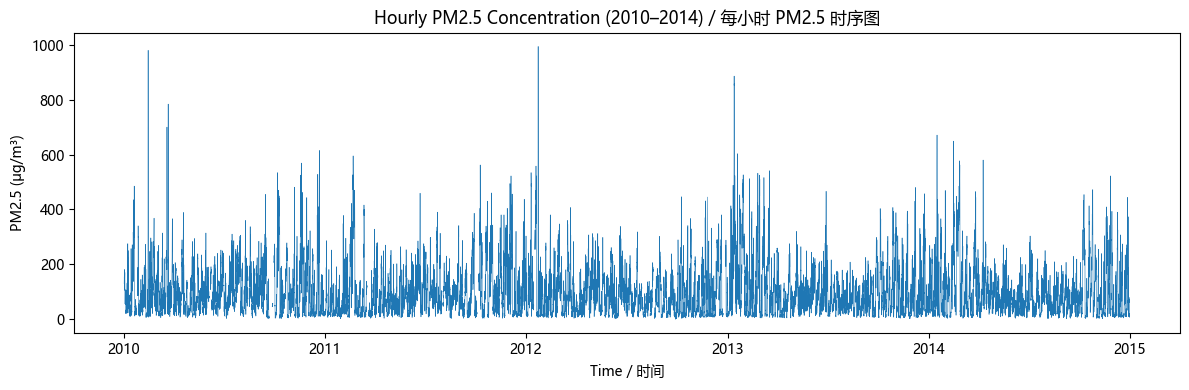

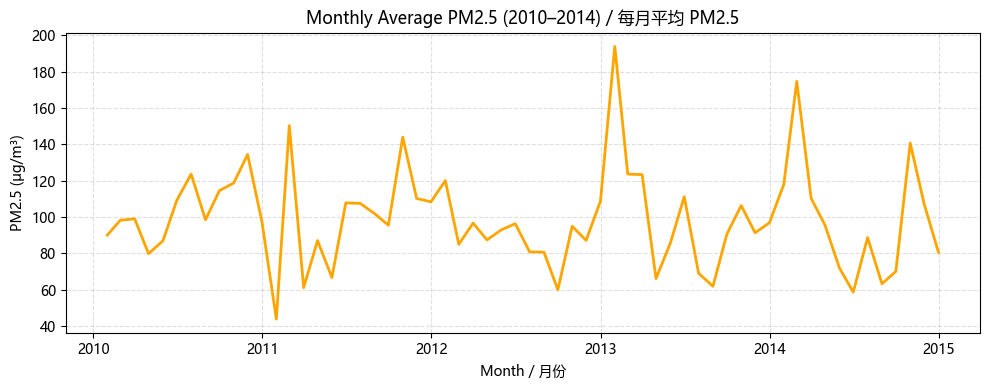

In [3]:
# 每小时 PM2.5 时序图 + 每月平均曲线
plt.figure(figsize=(12,4))
plt.plot(df.index, df['pm2.5'], lw=0.4)
plt.title("Hourly PM2.5 Concentration (2010–2014) / 每小时 PM2.5 时序图")
plt.xlabel("Time / 时间"); plt.ylabel("PM2.5 (μg/m³)")
plt.tight_layout(); plt.show()

monthly = df['pm2.5'].resample('ME').mean()
plt.figure(figsize=(10,4))
plt.plot(monthly.index, monthly.values, color='orange', lw=2)
plt.title("Monthly Average PM2.5 (2010–2014) / 每月平均 PM2.5")
plt.xlabel("Month / 月份"); plt.ylabel("PM2.5 (μg/m³)")
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout(); plt.show()

## Rolling Average Trend / 滚动平均趋势

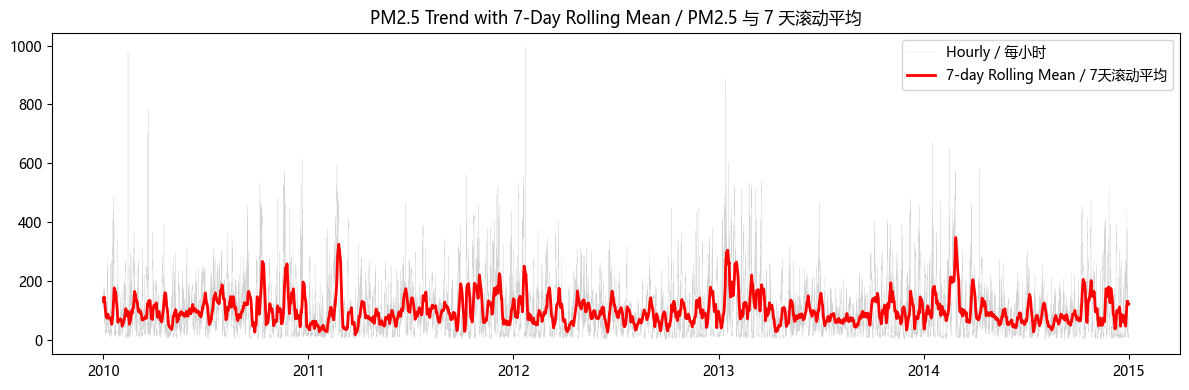

In [4]:
# 7-day rolling mean (168 hours)
df['pm25_rolling'] = df['pm2.5'].rolling(window=168, min_periods=1).mean()
plt.figure(figsize=(12,4))
plt.plot(df.index, df['pm2.5'], lw=0.2, color='lightgray', label='Hourly / 每小时')
plt.plot(df.index, df['pm25_rolling'], lw=2, color='red', label='7-day Rolling Mean / 7天滚动平均')
plt.title("PM2.5 Trend with 7-Day Rolling Mean / PM2.5 与 7 天滚动平均")
plt.legend(); plt.tight_layout(); plt.show()

## Modeling / 建模

In [1]:

from scipy import optimize
import numpy as np
import pandas as pd
df = pd.read_csv(r'D:\air-quality-portfolio\data\cleaned\air_quality_clean.csv')

def model_linear(Xdata, a, b, c, d):
    T, P, W = Xdata
    return a*T + b*P + c*W + d

def model_quad(Xdata, a, b, c, d, e):
    T, P, W = Xdata
    return a*T + b*T**2 + c*P + d*W + e

T = df['TEMP'].values
P = df['PRES'].values
W = df['Iws'].values
Y = df['pm2.5'].values

# 使用之前拟合结果
popt_lin = [-3.0765, -3.0323, -0.4556, 3229.8609]
popt_quad = [-2.5286, -0.0247, -3.0632, -0.4541, 3261.9007]
Y_pred_lin = model_linear((T,P,W), *popt_lin)
Y_pred_quad = model_quad((T,P,W), *popt_quad)

def r2_score(y, y_pred):
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res/ss_tot

r2_lin = 0.1141
r2_quad = 0.1154

print("Linear model parameters (stored):", popt_lin)
print("Quadratic model parameters (stored):", popt_quad)
print("\nReported R² (linear) =", r2_lin)
print("Reported R² (quadratic) =", r2_quad)

plt.figure(figsize=(6,6))
plt.scatter(Y, Y_pred_lin, s=3, alpha=0.4, label=f'Linear (R²=0.114)')
plt.scatter(Y, Y_pred_quad, s=3, alpha=0.4, label=f'Quadratic (R²=0.115)')
plt.plot([0,1000],[0,1000],'r--')
plt.xlabel('Actual PM2.5 / 实测 PM2.5'); plt.ylabel('Predicted PM2.5 / 预测值')
plt.legend(); plt.tight_layout(); plt.show()


Linear model parameters (stored): [-3.0765, -3.0323, -0.4556, 3229.8609]
Quadratic model parameters (stored): [-2.5286, -0.0247, -3.0632, -0.4541, 3261.9007]

Reported R² (linear) = 0.1141
Reported R² (quadratic) = 0.1154


NameError: name 'plt' is not defined

## Residual Analysis / 残差分析

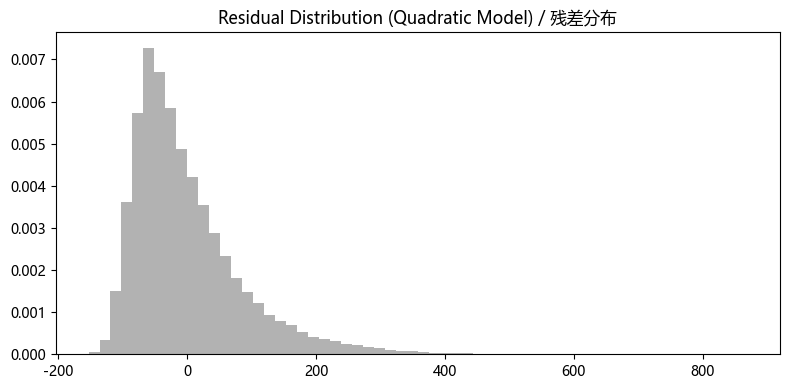

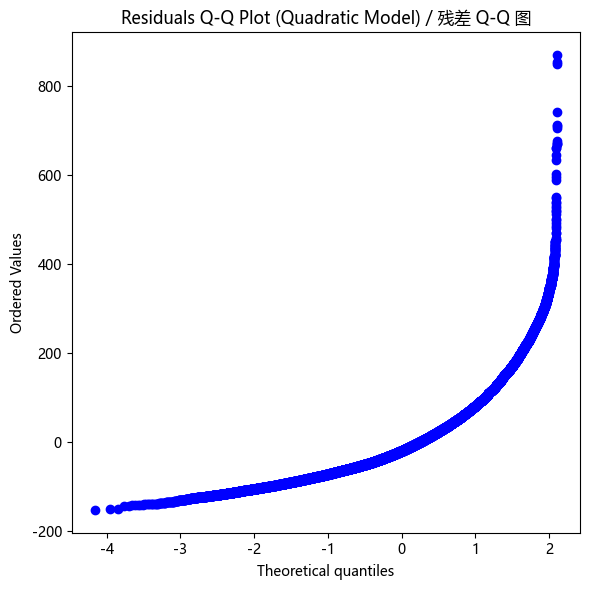

In [6]:
import scipy.stats as stats
resid = Y - Y_pred_quad
plt.figure(figsize=(8,4))
plt.hist(resid, bins=60, density=True, alpha=0.6, color='gray')
x = np.linspace(resid.min(), resid.max(), 300)
plt.plot(x, stats.norm.pdf(x, np.mean(resid), np.std(resid)), 'r', lw=2)
plt.title("Residual Distribution (Quadratic Model) / 残差分布")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,6))
stats.probplot(resid, dist="norm", plot=plt)
plt.title("Residuals Q-Q Plot (Quadratic Model) / 残差 Q-Q 图")
plt.tight_layout(); plt.show()

## Conclusion & Next Steps / 结论与后续

- 温度、气压和风速与 PM2.5 呈负相关，符合物理直觉。
- 引入温度二次项后，模型 R² 从 0.1141 提升到 0.1154。
- 后续可以尝试分季节建模或机器学习方法提升预测性能。